# VQGAN JAX Encoding for 🤗 Datasets

This notebook shows how to pre-encode images to token sequences using JAX, VQGAN and 🤗 Datasets (in streaming or normal modes).

This example uses our YFCC100M dataset, but it should be easy to adapt to any other image/caption dataset in the huggingface hub.

In [1]:
import io

import requests
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import os

import jax
from jax import pmap

## Dataset and Parameters

In [2]:
import datasets
from datasets import Dataset, load_dataset

We'll use the `validation` set for testing. Adjust accordingly.

In [3]:
dataset = load_dataset('dalle-mini/YFCC100M_OpenAI_subset', use_auth_token=True, streaming=True, split='validation')

Using custom data configuration default


In [4]:
from pathlib import Path

yfcc100m = Path.home()/'data'/'YFCC100M_OpenAI_subset'
yfcc100m_output = yfcc100m/'encoded'      # Output directory for encoded files

In [5]:
batch_size = 128     # Per device
num_workers = 16

### Data preparation

* Images: we transform them so they are center-cropped and square, all of the same size so we can build batches for TPU/GPU processing.
* Captions: we extract a single `caption` column from the source data, by concatenating the cleaned title and description.

These transformations are done using the Datasets `map` function. In the case of streaming datasets, transformations will run as needed instead of pre-processing the dataset at once.

This helper function is used to decode images from the bytes retrieved in `streaming` mode.

In [6]:
from PIL import Image
import io

def get_image(byte_stream):
    image = Image.open(io.BytesIO(byte_stream))
    return image.convert('RGB')

Image processing

In [7]:
def center_crop(image, max_size=256):
    # Note: we allow upscaling too. We should exclude small images.    
    image = TF.resize(image, max_size, interpolation=InterpolationMode.LANCZOS)
    image = TF.center_crop(image, output_size=2 * [max_size])
    return image

preprocess_image = T.Compose([
    get_image,
    center_crop,
    T.ToTensor(),
    lambda t: t.permute(1, 2, 0)   # Reorder, we need dimensions last
])

Caption preparation

In [8]:
import string

def create_caption(title, description):
    title = title.strip()
    description = description.strip()
    if len(title) > 0 and title[-1] not in '.!?': title += '.'
    return f'{title} {description}'

And this is the basic transformation function to use in `map`. We don't really need the `key`, but we'll keep it for reference. Since we are returning a new dictionary (as opposed to adding entries to the input), this also removes any metadata columns we don't need.

In [9]:
def prepare_item(item):
    return {
        'key': item['key'],
        'caption': create_caption(item['title_clean'], item['description_clean']),
        'image': preprocess_image(item['img'])
    }

Unlike when using non-streaming datasets, the following operation completes immediately in streaming mode. Samples will be processed as needed. We use a `batch_size` of the same size as the processing size to read as many items we'll consume in a dataloader step. We could use a different size, this way we do a retrieval per batch.

In [10]:
prepared_dataset = dataset.map(prepare_item, batched=False)

In [12]:
%%time
item = next(iter(prepared_dataset))

CPU times: user 5.85 s, sys: 1.23 s, total: 7.08 s
Wall time: 21.8 s


In [15]:
assert(list(item.keys()) == ['key', 'caption', 'image'])

In [17]:
item['image'].shape

torch.Size([256, 256, 3])

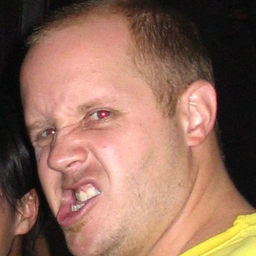

In [18]:
T.ToPILImage()(item['image'].permute(2, 0, 1))

### Torch DataLoader

We'll create a PyTorch DataLoader for convenience. This allows us to easily take batches of our desired size.

We won't be using parallel processing of the DataLoader for now, as the items will be retrieved on the fly. We could attempt to do it using these recommendations: https://pytorch.org/docs/stable/data.html#multi-process-data-loading.

In [15]:
import torch
from torch.utils.data import DataLoader

In [16]:
torch_dataset = prepared_dataset.with_format("torch")

In [17]:
torch_loader = DataLoader(torch_dataset, batch_size=batch_size * jax.device_count())

In [18]:
batch = next(iter(torch_loader))

In [19]:
batch['image'].shape

torch.Size([1024, 1, 256, 256, 3])

## VQGAN-JAX model

In [20]:
from vqgan_jax.modeling_flax_vqgan import VQModel

We'll use a VQGAN trained with Taming Transformers and converted to a JAX model.

In [21]:
model = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


## Encoding

Encoding is really simple using `shard` to automatically distribute "superbatches" across devices, and `pmap`. This is all it takes to create our encoding function, that will be jitted on first use.

In [22]:
from flax.training.common_utils import shard
from functools import partial

In [23]:
@partial(jax.pmap, axis_name="batch")
def encode(batch):
    # Not sure if we should `replicate` params, does not seem to have any effect
    _, indices = model.encode(batch)
    return indices

## Putting it all together

In [59]:
import os
import pandas as pd

def encode_captioned_dataset(dataset, prepare_function, output_dir, batch_size=32, num_workers=16, save_every=14):
    output_dir.mkdir(parents=True, exist_ok=True)
    
    num_tpus = jax.device_count()
    bs = batch_size * num_tpus
    
    prepared_dataset = dataset.map(prepare_function, batched=True, batch_size=batch_size * num_tpus)
    torch_dataset = prepared_dataset.with_format("torch")
    dataloader = DataLoader(torch_dataset, batch_size=batch_size * num_tpus, drop_last=True)
    
    # Saving strategy:
    # - Create a new file every so often to prevent excessive file seeking.
    # - Save each batch after processing.
    # - Keep the file open until we are done with it.
    file = None        
    iter_loader = iter(dataloader)
    for n, batch in tqdm(enumerate(iter_loader)):
        if (n % save_every == 0):
            if file is not None:
                file.close()
            split_num = n // save_every
            file = open(output_dir/f'split_{split_num:05x}.jsonl', 'w')

        images = batch["image"].numpy()
        images = shard(images.squeeze())
        encoded = encode(images)
        encoded = encoded.reshape(-1, encoded.shape[-1])

        # Extract captions from the dataset
        keys = batch["key"]
        captions = batch["caption"]

        encoded_as_string = list(map(lambda item: np.array2string(item, separator=',', max_line_width=50000, formatter={'int':lambda x: str(x)}), encoded))
        batch_df = pd.DataFrame.from_dict({"key": keys, "caption": captions, "encoding": encoded_as_string})
        batch_df.to_json(file, orient='records', lines=True)

Create a new file every 318 iterations. This should produce splits of ~500 MB each, when using a total batch size of 1024.

In [60]:
save_every = 318

In [61]:
encode_captioned_dataset(dataset, prepare_data, yfcc100m_output, batch_size=batch_size, num_workers=num_workers, save_every=save_every)

15it [03:14, 12.96s/it]


This is ~10-15 slower than local encoding from an SSD. We could try to inevistigate how to achieve some parallelization.

----